In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1005. Miscellaneous Analyses/P1005.6. Yael RNAseq Grant/P1005.6.3. Analyses/P1005.6.3.1 DESeq2/Output')
cur_date = "011724"

library(readxl)
library(openxlsx)
library(tidyverse)
library(reshape2)
library(data.table)
library(factoextra)
library(ggrepel)
library(pheatmap)
library(DESeq2)

# reading in files
count_df = data.frame(read_excel("Input/Yael_Counts_120223.xlsx")) 
subject_info_df = data.frame(read_excel("Input/SubjectInfo_120223.xlsx", sheet = 2))
asthma_gene_list_df = data.frame(read_excel("Input/Paper Gene List.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from

In [2]:
head(count_df)
head(subject_info_df)
head(asthma_gene_list_df)

,Gene,X1911_1,X1911_19,X1911_2,X1911_20,X1911_21,X1911_22,X1911_3,X1911_4,X1911_55,⋯,X2009_14,X2009_15,X2009_2,X2009_3,X2009_4,X2009_5,X2009_6,X2009_7,X2009_8,X2009_9
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CHAC1_1279,56,20,12,22,12,25,23,17,27,⋯,57,90,14,18,33,46,17,15,36,13
2,GLRX_2674,124,581,356,358,661,657,304,561,421,⋯,530,462,599,503,677,272,447,477,475,454
3,MEFV_4116,0,0,0,0,0,1,5,0,3,⋯,0,0,0,4,0,0,0,1,0,0
4,STXBP1_6866,55,95,172,120,121,77,200,97,85,⋯,109,99,121,92,71,132,136,143,165,183
5,AKAP8L_196,93,37,35,28,50,26,41,24,33,⋯,84,53,32,20,51,26,28,34,36,33
6,AKR1C1_199,670,723,513,415,1112,418,559,385,767,⋯,836,492,642,524,381,185,546,529,214,400


,Original_Sample_ID,Original_Subject_No,Subject_No,Subject_ID,Sample_ID,Replicate,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,X1911_62,NBL 190,1,AS_1,AS_1_C.1,1,F,B,NH,47,23.7,AS,C,Air
2,X1911_56,NBL 190,1,AS_1,AS_1_F.1,1,F,B,NH,47,23.7,AS,F,PGGLY
3,X1911_20,NBL 190,1,AS_1,AS_1_C.2,2,F,B,NH,47,23.7,AS,C,Air
4,X1911_2,NBL 190,1,AS_1,AS_1_S.1,1,F,B,NH,47,23.7,AS,S,PGGLY
5,X1911_64,NBL 193,2,AS_2,AS_2_C.1,1,F,W,NH,19,19.5,AS,C,Air
6,X1911_58,NBL 193,2,AS_2,AS_2_F.1,1,F,W,NH,19,19.5,AS,F,PGGLY


,Gene.Symbol,k,Hedges.g,std.error,tau.2,z.value,p.value,q.value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CEACAM5,8,1.0939910,0.1100273,0.01261454,9.942911,2.71e-23,1.00e-18
2,C3,8,-0.8490307,0.0983399,0.00000000,-8.633633,5.94e-18,1.10e-13
3,MUC5AC,7,0.8086030,0.1008032,0.00000000,8.021602,1.04e-15,1.29e-11
4,FUT3,8,0.7626832,0.0976211,0.00000000,7.812685,5.60e-15,5.17e-11
5,TCN1,7,0.7701838,0.1001925,0.00000000,7.687039,1.51e-14,9.33e-11
6,DQX1,8,0.7491184,0.0976080,0.00000000,7.674763,1.66e-14,9.33e-11


Using DESeq2 to determine if there are genes differentially expressed after exposure to nicotine products stratified by disease status.

In [3]:
# first replacing the column names in the count df with sample ids that are more descriptive of the subjects
# also filtering for asthma genes
cleaned_count_df = count_df %>%
    separate(Gene, sep = "_", c("Gene", NA)) %>%
    # only subsetting for asthma genes we're interested in 
    filter(Gene %in% asthma_gene_list_df$Gene.Symbol) %>%
    relocate(.after = Gene, subject_info_df$Original_Sample_ID) 

colnames(cleaned_count_df)[2:40] = subject_info_df$Sample_ID
head(cleaned_count_df)

,Gene,AS_1_C.1,AS_1_F.1,AS_1_C.2,AS_1_S.1,AS_2_C.1,AS_2_F.1,AS_2_C.2,AS_2_S.1,AS_3_C.1,⋯,NAS_8_C.2,NAS_8_S.1,NAS_9_C.1,NAS_9_F.1,NAS_9_C.2,NAS_9_S.1,NAS_10_C.1,NAS_10_F.1,NAS_10_C.2,NAS_10_S.1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,STXBP1,106,108,120,172,132,173,77,97,124,⋯,95,55,124,213,121,200,92,112,143,109
2,CTSL,197,188,224,170,180,143,192,164,150,⋯,141,479,234,179,212,298,108,164,165,206
3,ALDH18A1,16,17,27,40,10,21,29,18,22,⋯,22,68,12,17,19,19,29,22,32,37
4,ECH1,0,5,0,0,38,53,23,47,31,⋯,24,67,24,38,24,48,26,26,10,19
5,C3,1164,1576,1344,1268,179,206,422,301,525,⋯,1916,5037,1069,275,1551,776,353,576,635,1446
6,CASP7,790,932,964,1046,800,876,770,800,867,⋯,728,1500,853,892,930,1051,814,973,904,1033


In [4]:
# df now contains duplicate genes since the numbers were removed to match the asthma gene list
# creating a new col that identifies unique genes
make.unique = function(x, sep){
    # Function for making unique names. Input = vector (x) and what separator you want to use (sep), 
    # output = vector with duplicate names made unique using the separator and numbers
    ave(x, x, FUN = function(a){if(length(a) > 1){paste(a, 1:length(a), sep = sep)} 
                                else {a}})
}

# calling function
cleaned_count_df <- cleaned_count_df %>%
    mutate(Unique_Gene = make.unique(Gene, sep = "_")) %>%
    relocate(Unique_Gene, .after = Gene)

head(cleaned_count_df)

,Gene,Unique_Gene,AS_1_C.1,AS_1_F.1,AS_1_C.2,AS_1_S.1,AS_2_C.1,AS_2_F.1,AS_2_C.2,AS_2_S.1,⋯,NAS_8_C.2,NAS_8_S.1,NAS_9_C.1,NAS_9_F.1,NAS_9_C.2,NAS_9_S.1,NAS_10_C.1,NAS_10_F.1,NAS_10_C.2,NAS_10_S.1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,STXBP1,STXBP1,106,108,120,172,132,173,77,97,⋯,95,55,124,213,121,200,92,112,143,109
2,CTSL,CTSL_1,197,188,224,170,180,143,192,164,⋯,141,479,234,179,212,298,108,164,165,206
3,ALDH18A1,ALDH18A1,16,17,27,40,10,21,29,18,⋯,22,68,12,17,19,19,29,22,32,37
4,ECH1,ECH1,0,5,0,0,38,53,23,47,⋯,24,67,24,38,24,48,26,26,10,19
5,C3,C3,1164,1576,1344,1268,179,206,422,301,⋯,1916,5037,1069,275,1551,776,353,576,635,1446
6,CASP7,CASP7,790,932,964,1046,800,876,770,800,⋯,728,1500,853,892,930,1051,814,973,904,1033


In [5]:
# pivoting longer to average the replicate control samples
longer_count_df = cleaned_count_df %>%
    #rownames_to_column(var = "Gene") %>%
    pivot_longer(cols = 3:41, names_to = "Sample_ID", values_to = "Value") %>%
    # averaging count data across the replicate genes
    inner_join(subject_info_df[5:6]) %>%
    separate(Sample_ID, sep = "\\.", c("Sample_ID", NA)) %>%
    group_by(Unique_Gene, Sample_ID) %>%
    summarize(Value = round(mean(Value)))

head(longer_count_df)

Joining with `by = join_by(Sample_ID)`
`summarise()` has grouped output by 'Unique_Gene'. You can override using the
`.groups` argument.


Unique_Gene,Sample_ID,Value
<chr>,<chr>,<dbl>
A2M_1,AS_1_C,0
A2M_1,AS_1_F,0
A2M_1,AS_1_S,0
A2M_1,AS_2_C,0
A2M_1,AS_2_F,0
A2M_1,AS_2_S,0


In [6]:
# checking for duplicates
Dups = duplicated(longer_count_df)
summary(Dups)

   Mode   FALSE 
logical   38520 

No duplicates. Now creating dataframes that are formatted for succeeding code, as well as DESeq2 functions.

In [7]:
# first creating a `coldata` object that contains all the metadata for each sample
coldata_NAS = subject_info_df[,c(3:5,6:14)] %>%
    separate(Sample_ID, sep = "\\.", c("Sample_ID", NA)) %>%
    select(-Replicate) %>%
    unique() %>%
    filter(Disease_Status == 'NAS')

coldata_AS = subject_info_df[,c(3:5,6:14)] %>%
    separate(Sample_ID, sep = "\\.", c("Sample_ID", NA)) %>%
    select(-Replicate) %>%
    unique() %>%
    filter(Disease_Status == 'AS')

head(coldata_NAS)

,Subject_No,Subject_ID,Sample_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,7,NAS_7,NAS_7_C,F,B,NH,41,35.8,NAS,C,Air
2,7,NAS_7,NAS_7_F,F,B,NH,41,35.8,NAS,F,PGGLY
3,7,NAS_7,NAS_7_S,F,B,NH,41,35.8,NAS,S,PGGLY
4,8,NAS_8,NAS_8_C,M,W,NH,22,25.8,NAS,C,Air
5,8,NAS_8,NAS_8_F,M,W,NH,22,25.8,NAS,F,PGGLY
6,8,NAS_8,NAS_8_S,M,W,NH,22,25.8,NAS,S,PGGLY


In [8]:
# making a `countdata` obj that contains genes as rows and sample names as cols
countdata_NAS = longer_count_df %>%
    pivot_wider(names_from = "Sample_ID", values_from = "Value") %>%
    column_to_rownames(var = "Unique_Gene") %>%
    # filter for "AS" subjects only
    select(contains("NAS"))

countdata_AS = longer_count_df %>%
    pivot_wider(names_from = "Sample_ID", values_from = "Value") %>%
    column_to_rownames(var = "Unique_Gene") %>%
    # filter for "AS" subjects only
    select(!contains("NAS"))

head(countdata_NAS)

,NAS_10_C,NAS_10_F,NAS_10_S,NAS_7_C,NAS_7_F,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M_1,0,0,0,0,0,0,0,0,0,0,3,0
A2M_2,0,0,0,0,0,0,0,0,0,0,0,0
A4GALT,5229,5327,4469,3748,4491,4356,3006,3370,3906,3099,3544,2854
AADAC,20,20,13,134,121,116,12,4,1,20,70,4
AADAT,8,4,13,14,8,13,6,10,4,8,13,7
ABCA13,102,102,97,466,251,325,107,117,374,88,265,97


In [9]:
# checking for duplicates
summary(duplicated(coldata_NAS))
summary(duplicated(countdata_NAS))

# getting dimensions
dim(coldata_NAS)
dim(countdata_NAS)
dim(countdata_AS)

   Mode   FALSE 
logical      12 

   Mode   FALSE    TRUE 
logical    1220      64 

[1] 12 11

[1] 1284   12

[1] 1284   18

In [10]:
# checking duplicates
dups_NAS = rownames(countdata_NAS)[duplicated(countdata_NAS)]
dups_AS = rownames(countdata_AS)[duplicated(countdata_AS)]

head(countdata_NAS[dups_NAS,])

,NAS_10_C,NAS_10_F,NAS_10_S,NAS_7_C,NAS_7_F,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AHSG,0,0,0,0,0,0,0,0,0,0,0,0
ANO4,0,0,0,0,0,0,0,0,0,0,0,0
C1orf122,0,0,0,0,0,0,0,0,0,0,0,0
C3orf22,0,0,0,0,0,0,0,0,0,0,0,0
CCK_2,0,0,0,0,0,0,0,1,0,0,0,0
CD28,0,0,0,0,0,0,0,0,0,0,0,0


These are considered duplicates since all the data contains zeros, but the df doesn't actually contain duplicate genes or columns. 

In [11]:
# Set the rownames of coldata and column names of countdata to be in the same order 
countdata_NAS <- setcolorder(countdata_NAS, as.character(coldata_NAS$Sample_ID))
countdata_AS <- setcolorder(countdata_AS, as.character(coldata_AS$Sample_ID))

head(countdata_NAS)

,NAS_7_C,NAS_7_F,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M_1,0,0,0,0,0,0,0,3,0,0,0,0
A2M_2,0,0,0,0,0,0,0,0,0,0,0,0
A4GALT,3748,4491,4356,3006,3370,3906,3099,3544,2854,5229,5327,4469
AADAC,134,121,116,12,4,1,20,70,4,20,20,13
AADAT,14,8,13,6,10,4,8,13,7,8,4,13
ABCA13,466,251,325,107,117,374,88,265,97,102,102,97


In [12]:
# Double checking that the same variables appear between the two dataframes
setequal(as.character(coldata_NAS$Sample_ID), colnames(countdata_NAS))
setequal(as.character(coldata_AS$Sample_ID), colnames(countdata_AS))

# Additionally checking that not only the sets of variables are the same, but that they are in the same order
identical(as.character(coldata_NAS$Sample_ID), colnames(countdata_NAS))
identical(as.character(coldata_AS$Sample_ID), colnames(countdata_AS))

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

# Transcriptomics QA/QC 
Performed on raw count data to identify potential outlier samples. Starting by filtering lowly expressed genes.

In [13]:
# First count the total number of samples and save it as a value in the global environment
nsamp_NAS <- ncol(countdata_NAS)
nsamp_AS <- ncol(countdata_AS)

# Then, calculate the median expression level across all genes and all samples and save it as a value
total_median_NAS <- median(as.matrix(countdata_NAS), na.rm = TRUE)
total_median_AS <- median(as.matrix(countdata_AS), na.rm = TRUE)

# We need to temporarily add back in the gene column to the countdata 
# so we can filter for genes that pass the background filter
countdata_NAS <- countdata_NAS %>% 
    rownames_to_column("Gene")
countdata_AS <- countdata_AS %>% 
    rownames_to_column("Gene")

head(countdata_NAS)

,Gene,NAS_7_C,NAS_7_F,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A2M_1,0,0,0,0,0,0,0,3,0,0,0,0
2,A2M_2,0,0,0,0,0,0,0,0,0,0,0,0
3,A4GALT,3748,4491,4356,3006,3370,3906,3099,3544,2854,5229,5327,4469
4,AADAC,134,121,116,12,4,1,20,70,4,20,20,13
5,AADAT,14,8,13,6,10,4,8,13,7,8,4,13
6,ABCA13,466,251,325,107,117,374,88,265,97,102,102,97


In [14]:
# filtering for genes that have an expression greater than the total median in at least 20% of the samples
genes_above_background_NAS <- countdata_NAS %>% 
    pivot_longer(cols =! Gene, names_to = "sampleID", values_to = "expression") %>% 
    # indicates whether the expression of a gene for the corresponding exposure condition is above (1) or not 
    # above (0) the median of all count data
    mutate(above_median = ifelse(expression > total_median_NAS, 1, 0)) %>% 
    group_by(Gene) %>% 
    # For each gene, count the number of exposure conditions where the expression was greater than the median 
    # of all count data
    summarize(total_above_median = sum(above_median)) %>% 
    # Filter for genes that have expression above the median in at least 20% of the samples
    filter(total_above_median >= 0.2*nsamp_NAS) %>% 
    select(Gene) 

genes_above_background_AS <- countdata_AS %>% 
    pivot_longer(cols =! Gene, names_to = "sampleID", values_to = "expression") %>% 
    mutate(above_median = ifelse(expression > total_median_AS, 1, 0)) %>% 
    group_by(Gene) %>% 
    summarize(total_above_median = sum(above_median)) %>% 
    filter(total_above_median >= 0.2*nsamp_AS) %>% 
    select(Gene) 

# Then filter the original 'countdata' dataframe for only the genes above background. 
countdata_NAS <- left_join(genes_above_background_NAS, countdata_NAS, by = "Gene")
countdata_AS <- left_join(genes_above_background_AS, countdata_AS, by = "Gene")

dim(countdata_NAS)
dim(countdata_AS)

[1] 706  13

[1] 726  19

This dataframe went from having 1,284 genes to 706 genes for healthy subjects and 726 for asthmatic subjects. Now filtering samples with no expression. 

In [15]:
countdata_T_NAS <- countdata_NAS %>% 
  pivot_longer(cols =! Gene, names_to = "sampleID",values_to = "expression") %>% 
  pivot_wider(names_from = Gene, values_from = expression)

countdata_T_AS <- countdata_AS %>% 
  pivot_longer(cols =! Gene, names_to = "sampleID",values_to = "expression") %>% 
  pivot_wider(names_from = Gene, values_from = expression)

# Then add in a column to the transposed countdata dataframe that sums expression across all genes for each 
# exposure condition
countdata_T_NAS$rowsum <- rowSums(countdata_T_NAS[2:ncol(countdata_T_NAS)])
countdata_T_AS$rowsum <- rowSums(countdata_T_AS[2:ncol(countdata_T_AS)])

# Remove samples that have no expression
countdata_T_NAS <- countdata_T_NAS %>% 
    filter(rowsum != 0)
countdata_T_AS <- countdata_T_AS %>% 
    filter(rowsum != 0)

# Take the count data filtered for correct samples, remove the 'rowsums' column
countdata_T_NAS <- countdata_T_NAS %>% 
    select(!rowsum) 
countdata_T_AS <- countdata_T_AS %>% 
    select(!rowsum) 

# Then, transpose it back to the correct format for analysis
countdata_NAS <- countdata_T_NAS %>%
  pivot_longer(cols =! sampleID, names_to = "Gene", values_to = "expression") %>% 
  pivot_wider(names_from = sampleID, values_from = "expression") %>%
    column_to_rownames(var = "Gene")
countdata_AS <- countdata_T_AS %>%
  pivot_longer(cols =! sampleID, names_to = "Gene", values_to = "expression") %>% 
  pivot_wider(names_from = sampleID, values_from = "expression") %>%
    column_to_rownames(var = "Gene")

dim(countdata_NAS)
dim(countdata_AS)

[1] 706  12

[1] 726  18

No samples were removed. Now finding and removing sample outliers using PCA and hierarchical clustering.

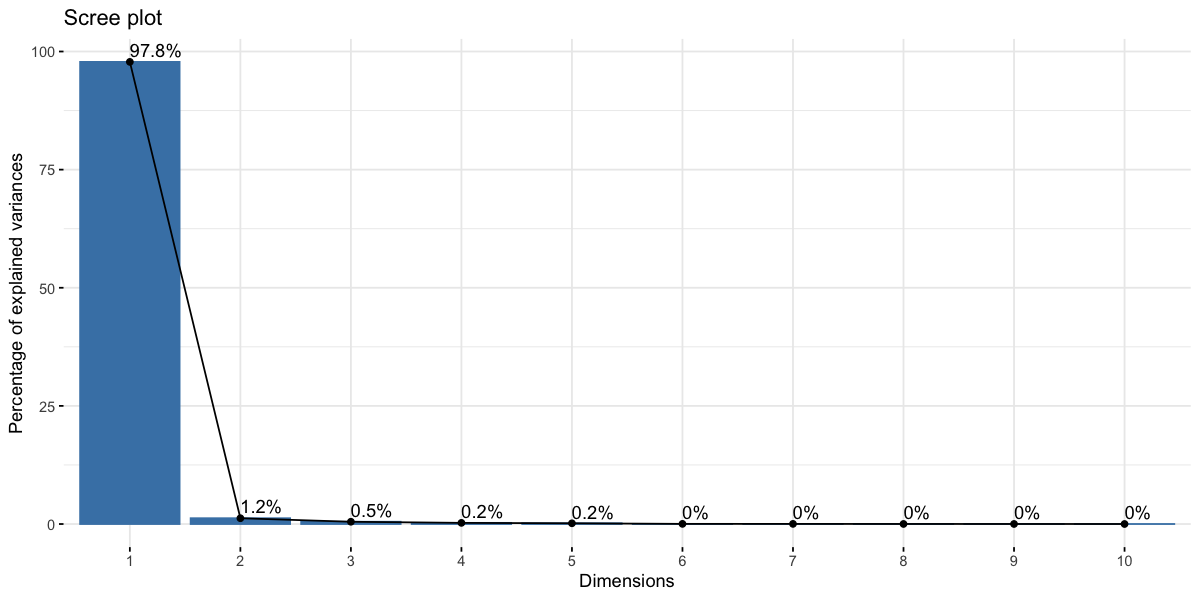

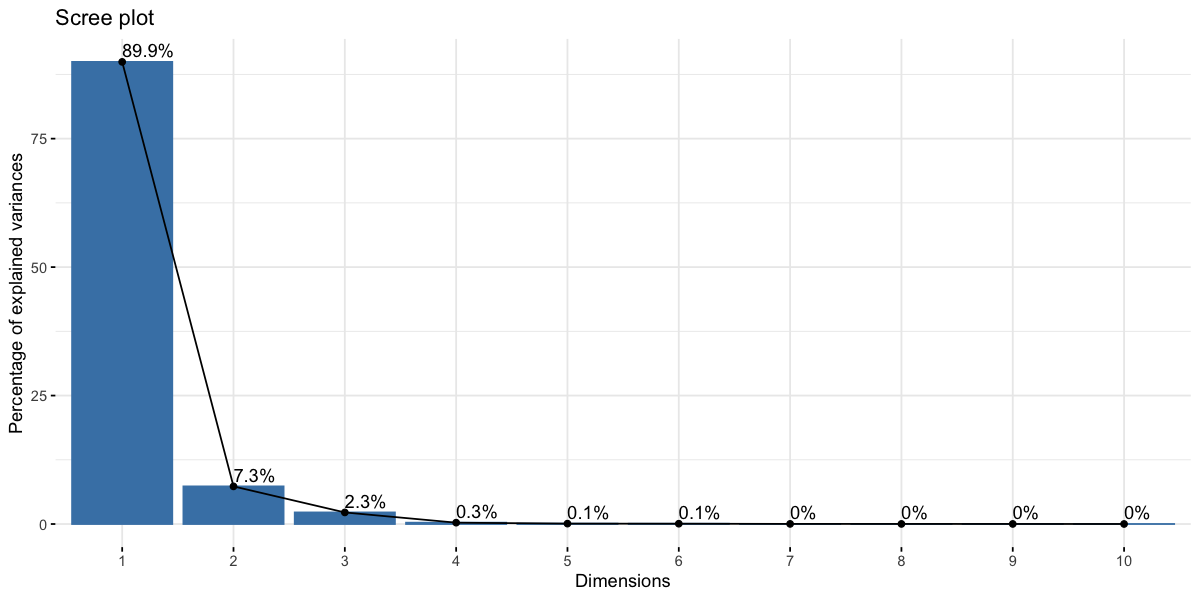

In [16]:
# PCA helps in identifying outlying samples for quality control and gives a feeling for 
# the principal causes of variation in a dataset

# Calculate principal components using transposed count data
pca_NAS <- prcomp(t(countdata_NAS))
pca_AS <- prcomp(t(countdata_AS))

options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(pca_NAS, addlabels = TRUE)
fviz_eig(pca_AS, addlabels = TRUE)

In [17]:
# Make dataframe for PCA plot generation using first two components and the sample name
pca_df_NAS <- data.frame(PC1 = pca_NAS$x[,1], PC2 = pca_NAS$x[,2], Sample_ID = colnames(countdata_NAS))
pca_df_AS <- data.frame(PC1 = pca_AS$x[,1], PC2 = pca_AS$x[,2], Sample_ID = colnames(countdata_AS))

# Calculating percent of the variation that is captured by each principal component
pca_percent_NAS <- round(100 * pca_NAS$sdev^2/sum(pca_NAS$sdev^2), 1)
pca_percent_AS <- round(100 * pca_AS$sdev^2/sum(pca_AS$sdev^2), 1)

# Organize dataframe so we can color our points by burn condition
pca_df_NAS <- pca_df_NAS %>% 
    inner_join(coldata_NAS)
pca_df_AS <- pca_df_AS %>% 
    inner_join(coldata_AS)

head(pca_df_NAS)

Joining with `by = join_by(Sample_ID)`
Joining with `by = join_by(Sample_ID)`


,PC1,PC2,Sample_ID,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,-236086.9,-24249.43,NAS_7_C,7,NAS_7,F,B,NH,41,35.8,NAS,C,Air
2,-228015.7,-23678.25,NAS_7_F,7,NAS_7,F,B,NH,41,35.8,NAS,F,PGGLY
3,-240138.3,-23085.06,NAS_7_S,7,NAS_7,F,B,NH,41,35.8,NAS,S,PGGLY
4,365669.7,-30670.65,NAS_8_C,8,NAS_8,M,W,NH,22,25.8,NAS,C,Air
5,439233.7,-28042.23,NAS_8_F,8,NAS_8,M,W,NH,22,25.8,NAS,F,PGGLY
6,187828.8,16970.47,NAS_8_S,8,NAS_8,M,W,NH,22,25.8,NAS,S,PGGLY


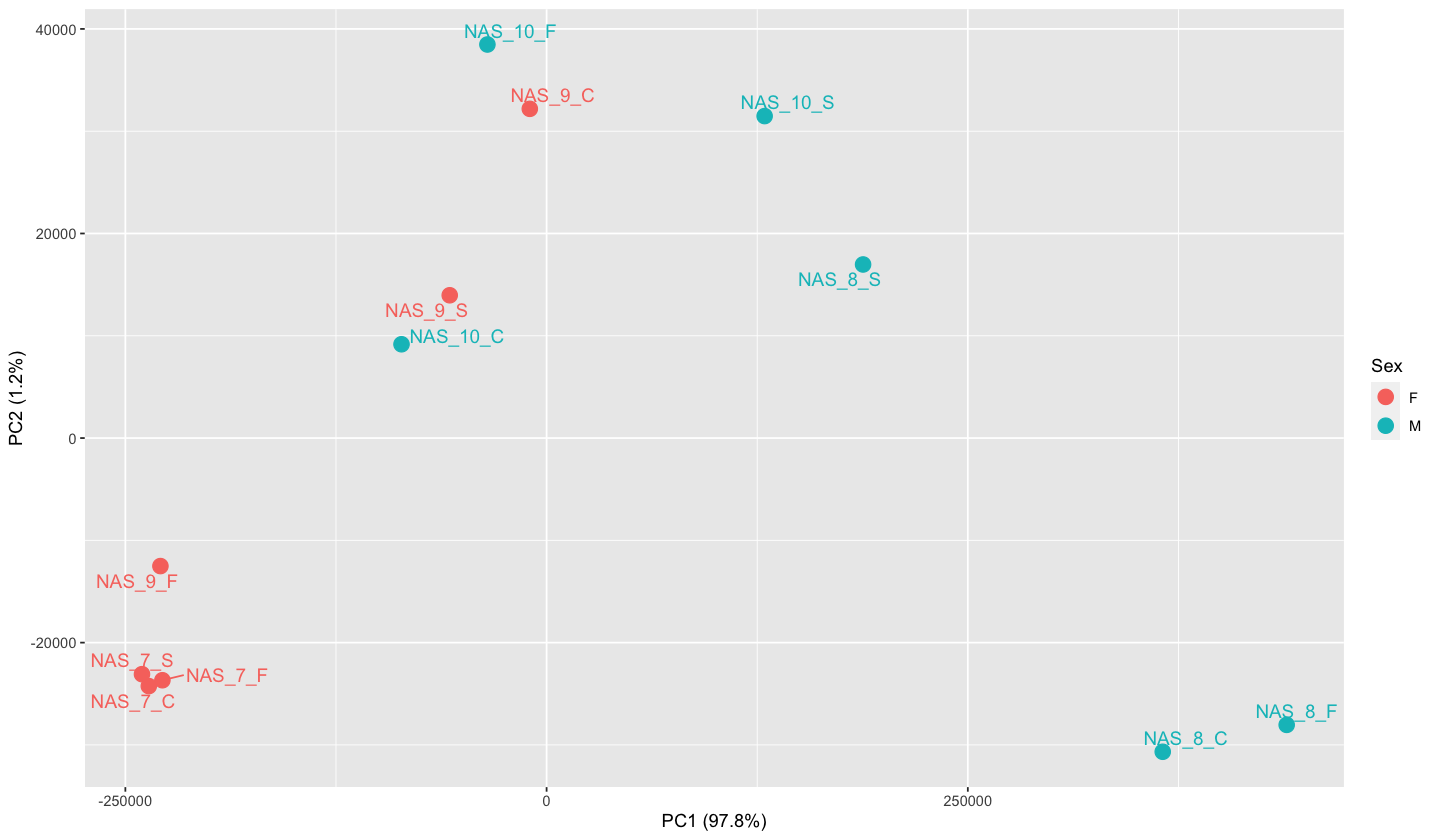

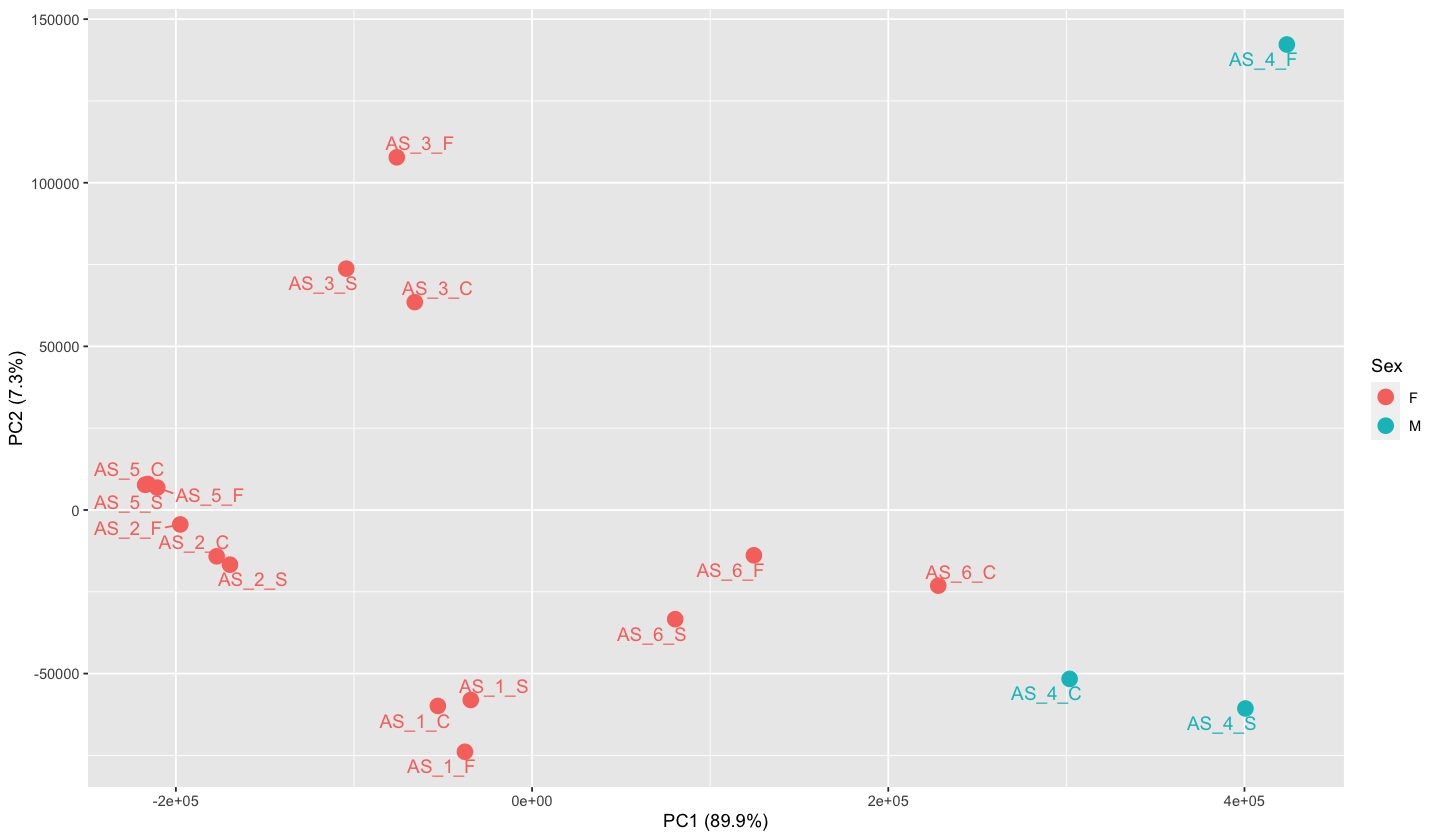

In [18]:
options(repr.plot.width=12, repr.plot.height=7) #changing size

# color by sex since that's a covariate we're interested in
ggplot(pca_df_NAS, aes(PC1, PC2, color = Sex)) +
  geom_point(size = 4) +
  geom_text_repel(aes(label = Sample_ID), size = 4) +
  labs(x = paste0("PC1 (",pca_percent_NAS[1],"%)"), y = paste0("PC2 (",pca_percent_NAS[2],"%)"))

ggplot(pca_df_AS, aes(PC1, PC2, color = Sex)) +
  geom_point(size = 4) +
  geom_text_repel(aes(label = Sample_ID), size = 4) +
  labs(x = paste0("PC1 (",pca_percent_AS[1],"%)"), y = paste0("PC2 (",pca_percent_AS[2],"%)"))

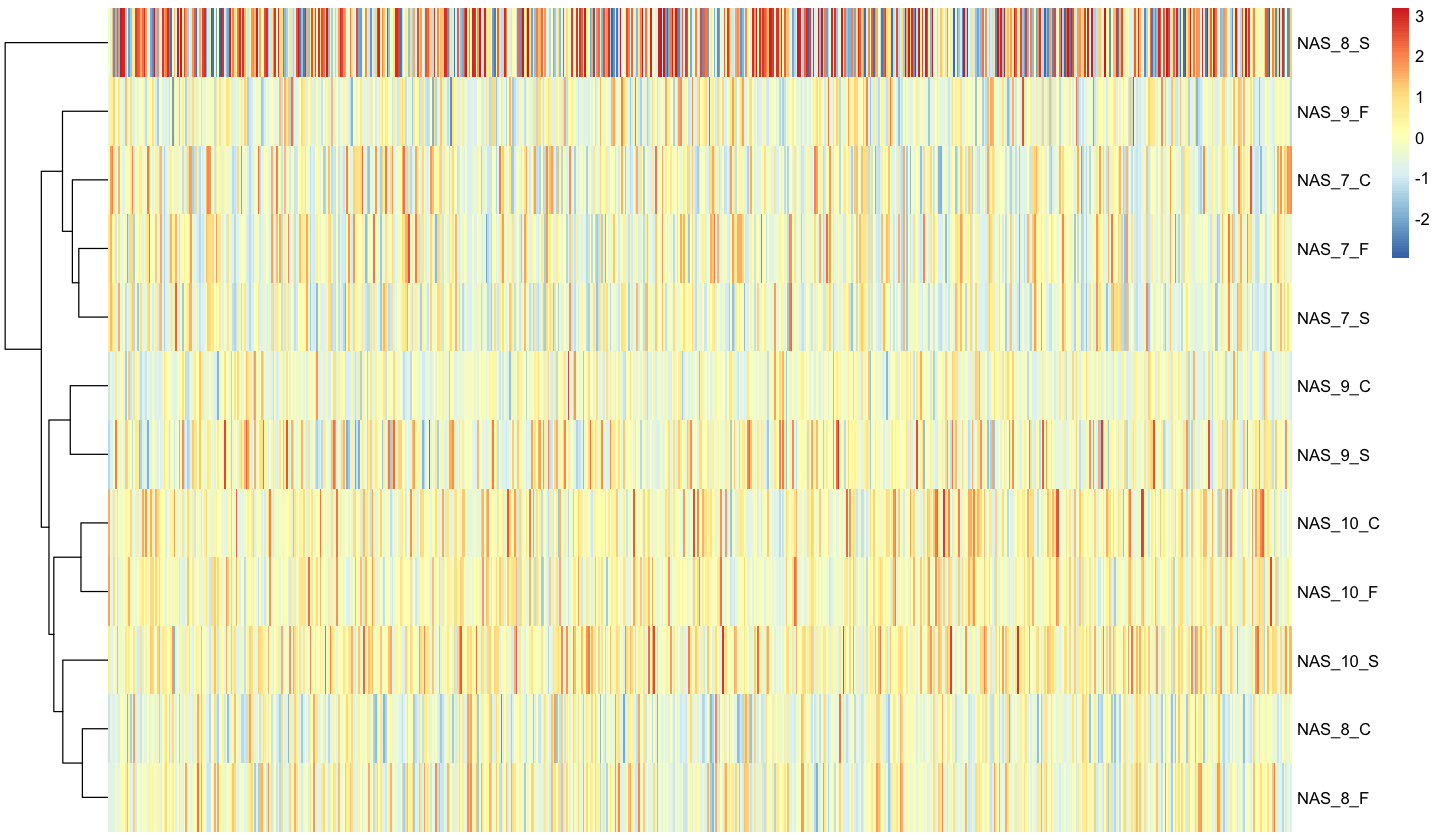

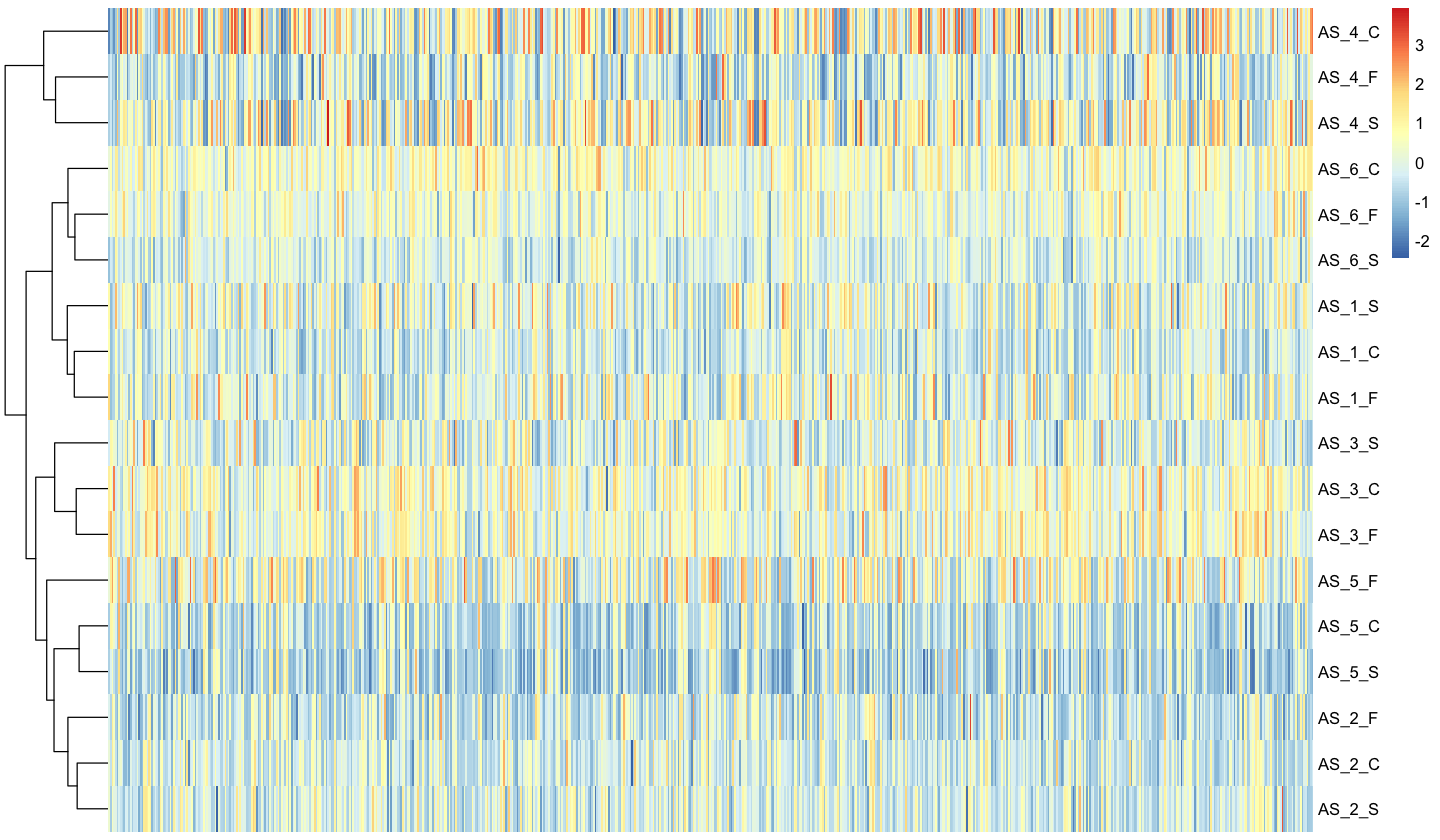

In [19]:
countdata_for_clustering_NAS <- t(countdata_NAS)
countdata_for_clustering_AS <- t(countdata_AS)

pheatmap(scale(countdata_for_clustering_NAS), 
         cluster_rows = TRUE, cluster_cols = FALSE, fontsize_col = 7, treeheight_row = 60, show_colnames = FALSE)
pheatmap(scale(countdata_for_clustering_AS), 
         cluster_rows = TRUE, cluster_cols = FALSE, fontsize_col = 7, treeheight_row = 60, show_colnames = FALSE)

There were no clear sample outliers from PCA or hierarchical clustering, so now we'll use a quantitative approach. The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/) However, from the PCA plot there do appear to be sex differences. 

# DESeq2 Experiment

In [20]:
# Starting with putting variables into factors
coldata_NAS$Disease_Status = factor(coldata_NAS$Disease_Status)
coldata_NAS$Exposure = factor(coldata_NAS$Exposure)
coldata_AS$Disease_Status = factor(coldata_AS$Disease_Status)
coldata_AS$Exposure = factor(coldata_AS$Exposure)
#coldata$Sex = factor(coldata$Sex)
#coldata$Subject_No = factor(coldata$Subject_No)

In [21]:
head(countdata_NAS)
head(coldata_NAS)

,NAS_7_C,NAS_7_F,NAS_7_S,NAS_8_C,NAS_8_F,NAS_8_S,NAS_9_C,NAS_9_F,NAS_9_S,NAS_10_C,NAS_10_F,NAS_10_S
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A4GALT,3748,4491,4356,3006,3370,3906,3099,3544,2854,5229,5327,4469
AADAC,134,121,116,12,4,1,20,70,4,20,20,13
ABCA13,466,251,325,107,117,374,88,265,97,102,102,97
ABHD17C,1009,850,919,518,541,66,583,1120,771,1018,1072,762
ABHD2,757,659,725,906,974,1740,1350,914,1870,964,911,902
ABRACL,1760,2170,1606,2684,2608,170,2078,2023,2330,2968,3033,3482


,Subject_No,Subject_ID,Sample_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Exposure,Medium
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>
1,7,NAS_7,NAS_7_C,F,B,NH,41,35.8,NAS,C,Air
2,7,NAS_7,NAS_7_F,F,B,NH,41,35.8,NAS,F,PGGLY
3,7,NAS_7,NAS_7_S,F,B,NH,41,35.8,NAS,S,PGGLY
4,8,NAS_8,NAS_8_C,M,W,NH,22,25.8,NAS,C,Air
5,8,NAS_8,NAS_8_F,M,W,NH,22,25.8,NAS,F,PGGLY
6,8,NAS_8,NAS_8_S,M,W,NH,22,25.8,NAS,S,PGGLY


We're interested in comparing exposure groups. 

> Design #1: Exposure

In [22]:
# Our design indicates that our count data is dependent on the exposure condition 
# (Exposure variable) and our factor of unwanted variation, and we have specified 
# that there not be an intercept term through the use of '~0'

# crude model
dds <- DESeqDataSetFromMatrix(countData = countdata_NAS, colData = coldata_NAS, design = ~Exposure) 
# adding in exposure and sex as covariates
dds_AS <- DESeqDataSetFromMatrix(countData = countdata_AS, colData = coldata_AS, design = ~Exposure) 

# View what the experiment contains
dds

converting counts to integer mode

converting counts to integer mode



class: DESeqDataSet 
dim: 706 12 
metadata(1): version
assays(1): counts
rownames(706): A4GALT AADAC ... ZNF841_1 ZNF841_2
rowData names(0):
colnames(12): NAS_7_C NAS_7_F ... NAS_10_F NAS_10_S
colData names(11): Subject_No Subject_ID ... Exposure Medium

In [23]:
# make sure that we have the main contrast in the order we want to calculate appropriate fold change values
dds$Exposure <- relevel (dds$Exposure, "C")
dds_AS$Exposure <- relevel (dds_AS$Exposure, "C")

# estimate the size factors, since size factors are used to normalize the counts (next step)
# The "iterate" estimator iterates between estimating the dispersion with a design of ~1, 
# and finding a size factor vector by numerically optimizing the likelihood of the ~1 model.
dds <- estimateSizeFactors(dds)
dds_AS <- estimateSizeFactors(dds_AS)

sizeFactors(dds) 
sizeFactors(dds_AS) 

NAS_7_C   NAS_7_F   NAS_7_S   NAS_8_C   NAS_8_F   NAS_8_S   NAS_9_C   NAS_9_F 
0.9702065 0.9690178 0.9200488 0.9313764 0.9941584 1.1877697 0.9727325 0.9403839 
  NAS_9_S  NAS_10_C  NAS_10_F  NAS_10_S 
1.0315918 1.0729194 1.0573405 1.1595554

AS_1_C    AS_1_F    AS_1_S    AS_2_C    AS_2_F    AS_2_S    AS_3_C    AS_3_F 
0.9567593 1.0447215 1.0496997 0.9283996 0.8780704 0.9423850 1.1595319 1.1541288 
   AS_3_S    AS_4_C    AS_4_F    AS_4_S    AS_5_C    AS_5_F    AS_5_S    AS_6_C 
1.0109611 1.1316266 0.9509288 1.1427541 0.8340809 1.0464029 0.7609403 1.1881138 
   AS_6_F    AS_6_S 
1.1208803 1.0179073

In [24]:
# normalized counts
normcounts <- counts(dds, normalized = TRUE)
normcounts_AS <- counts(dds_AS, normalized = TRUE)

# log2 pseudocounts
log2normcounts <- log2(normcounts + 1)
log2normcounts_AS <- log2(normcounts_AS + 1)

In [25]:
# Background filter: remove rows with only zeros or only a single count across all samples
idx <- rowSums(normcounts) > 1     
CountsAboveBack <- normcounts[idx,]
nrow(CountsAboveBack)

idx_AS <- rowSums(normcounts_AS) > 1     
CountsAboveBack_AS <- normcounts_AS[idx_AS,]
nrow(CountsAboveBack_AS)
    
# Also need to filter in the entire DESeq2 experiment
dds <- dds[rowSums(counts(dds, normalized = TRUE)) > 1, ]
dds_AS <- dds_AS[rowSums(counts(dds_AS, normalized = TRUE)) > 1, ]

[1] 706

[1] 726

No genes were removed. 
# Statistical Analysis to detect Differentially Expressed Genes

In [26]:
# Running the differential expression statistical pipeline
# because we used a user-defined model matrix, need to set betaPrior = FALSE
dds <- DESeq(dds, betaPrior = FALSE) 
dds_AS <- DESeq(dds_AS, betaPrior = FALSE) 

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [27]:
# creating a df of contrasts for the function to loop through
contrasts_df = data.frame(Exposure1 = c("C", "C", "S"), Exposure2 = c("S", "F", "F"))
head(contrasts_df)

,Exposure1,Exposure2
,<chr>,<chr>
1,C,S
2,C,F
3,S,F


In [28]:
#start of running loop to compare all samples
statistical_results = function(dds_experiment, subjects){
    
    significant_genes_df = data.frame()
    for (i in 1:length(contrasts_df$Exposure1)){
    
        # Pulling statistical results
        #Statistical output with multiple test correction by the default, BH (aka FDR)
        res <- results(dds_experiment, pAdjustMethod = "BH", contrast = c("Exposure", contrasts_df$Exposure1[i], 
                                                                          contrasts_df$Exposure2[i]))
        
        # Exporting statistical results
        res_df = data.frame(res)[order(res$padj),] 
        filtered_res_df = res_df %>% 
            # adding exposure comparisons
            mutate(Exposure1 = contrasts_df$Exposure1[i], Exposure2 = contrasts_df$Exposure2[i], Subjects = subjects) %>%
            rownames_to_column(var = "Gene")

        # saving results
        significant_genes_df = rbind(significant_genes_df, filtered_res_df)
        
      }
    
    return(significant_genes_df)
}

# calling function 
genes_NAS_df = statistical_results(dds, "NAS")
genes_AS_df = statistical_results(dds_AS, "AS")

head(genes_NAS_df)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Exposure1,Exposure2,Subjects
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,KLF4,940.71492,-0.96731311,0.2938101,-3.2923074,0.0009936894,0.6965763,C,S,NAS
2,A4GALT,3885.41269,0.04916903,0.2464075,0.1995435,0.8418375908,0.9964933,C,S,NAS
3,AADAC,46.20472,0.42477914,1.2401719,0.3425163,0.7319623540,0.9964933,C,S,NAS
4,ABCA13,198.45912,-0.11532741,0.6751904,-0.1708072,0.8643753438,0.9964933,C,S,NAS
5,ABHD17C,769.12443,0.35502082,0.6181815,0.5742987,0.5657657139,0.9964933,C,S,NAS
6,ABHD2,1031.35063,-0.26205982,0.3343576,-0.7837710,0.4331744884,0.9964933,C,S,NAS


In [29]:
# table of asthma genes that were statistically significant
final_df = rbind(genes_NAS_df, genes_AS_df) %>%
    # changing exposure classes for interpretability
    mutate(Exposure1 = ifelse(Exposure1 == "C", "Control",
                            ifelse(Exposure1 == "S", "Nicotine Salts",
                                   ifelse(Exposure1 == "F", "Freebase Nicotine", NA))),
           Exposure2 = ifelse(Exposure2 == "C", "Control",
                            ifelse(Exposure2 == "S", "Nicotine Salts",
                                   ifelse(Exposure2 == "F", "Freebase Nicotine", NA))))

head(final_df)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Exposure1,Exposure2,Subjects
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,KLF4,940.71492,-0.96731311,0.2938101,-3.2923074,0.0009936894,0.6965763,Control,Nicotine Salts,NAS
2,A4GALT,3885.41269,0.04916903,0.2464075,0.1995435,0.8418375908,0.9964933,Control,Nicotine Salts,NAS
3,AADAC,46.20472,0.42477914,1.2401719,0.3425163,0.7319623540,0.9964933,Control,Nicotine Salts,NAS
4,ABCA13,198.45912,-0.11532741,0.6751904,-0.1708072,0.8643753438,0.9964933,Control,Nicotine Salts,NAS
5,ABHD17C,769.12443,0.35502082,0.6181815,0.5742987,0.5657657139,0.9964933,Control,Nicotine Salts,NAS
6,ABHD2,1031.35063,-0.26205982,0.3343576,-0.7837710,0.4331744884,0.9964933,Control,Nicotine Salts,NAS


In [30]:
# total significant gene counts
sig_genes_count_df = final_df %>%
    # filtering for only sig genes
    filter(pvalue < 0.05) %>%
    group_by(Subjects) %>%
    summarize(n())

sig_genes_count_df

Subjects,n()
<chr>,<int>
AS,15
NAS,45


In [31]:
# exporting
write.xlsx(final_df, paste0(Output,"/", "Stratified_Exposure_DESeq2_", cur_date, ".xlsx"), 
           rowNames = FALSE)